# Homework 5.1: Logistic regression, hyperparameter optimization 

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gdown

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Exercise 1: implementing `DummyClassifier`
<hr>
rubric={points:25}

You will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more label(0) than label(1) it predicts label(0) every time, and if there are more label(1) than label(0) it predicts label(1) every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% label(0) 70% label(1) it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get you started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of [`DummyClassifier(strategy='prior')`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html?highlight=dummyclassifier+strategy+prior). Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    def __init__(self):
        # BEGIN YOUR CODE HERE
        self.count0 = 0
        self.count1 = 0
        self.freq0 = 0
        self.freq1 = 0
        self.total_data = 0
        # END YOUR CODE HERE
        return None
        
    def fit(self, X, y):
        # BEGIN YOUR CODE HERE
        self.count0 = np.count_nonzero(y==0)
        self.count1 = np.count_nonzero(y==1)
        self.total_data = len(y)
        self.freq0 = self.count0/(float)(self.total_data)
        self.freq1 = self.count1/(float)(self.total_data)
        # END YOUR CODE HERE
        return None


    def predict(self, X):
        # BEGIN YOUR CODE HERE
        size_data = len(X)
        predict_array = []
        if self.count0 > self.count1:
            predict_array = np.zeros(size_data, dtype = int)
        else:
            predict_array = np.ones(size_data, dtype = int)
        
        # END YOUR CODE HERE
        return predict_array
   

    def predict_proba(self, X):
        # BEGIN YOUR CODE HERE
        size_data = len(X)
        proba_array = []
        # proba_array = np.array(proba_array, dtype=float)
        for length in range(0, size_data):
            proba_array.append([self.freq0,self.freq1])
        # proba_array = zip(*proba_array)    
        # print(proba_array)
        # END YOUR CODE HERE
        return proba_array


    def score(self, X, y):
        # BEGIN YOUR CODE HERE
        value = []
        value = self.predict(y)
        size_data = len(y)
        count = 0
        for items in range(0,size_data):
            if (value[items] == y[items]):
                count+=1
        score_value = count/(float)(size_data)        
        print(score_value)
            
        
        
        # END YOUR CODE HERE
        return score_value

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

#print(sk_dc.predict_proba(X_train_dummy))
#print(sk_dc.predict_proba(X_valid_dummy))
print(sk_dc.score(X_train_dummy, y_train_dummy))
print(sk_dc.score(X_valid_dummy, y_valid_dummy))

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

0.5148514851485149
0.5714285714285714


Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy))
assert np.allclose(my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy))

Below are some tests for `score`.

In [5]:
assert np.isclose(my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy))
assert np.isclose(my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy))

0.5148514851485149
0.5714285714285714


## Exercise 2: Trump Tweets
<hr>
rubric={points:35}

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. 

**As usual, please do not submit the dataset when you submit the assignment.**

In [6]:
if not os.path.exists("realdonaldtrump.csv"):
    url = "https://drive.google.com/file/d/1xeYHzPhraO6rVqWa70Pp9T_xUHjaFMk0/view?usp=sharing"
    output = "realdonaldtrump.csv"
    md5 = "dce8232309417781a68ab484ff23fa94"
    gdown.cached_download(url, output, md5=md5, fuzzy=True)

In [7]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [8]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [9]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [10]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. {points: 4} 
- Add a short comment to each block to describe what the code is doing. {points: 4}


In [11]:
'''
You can skip this cell and insert your code in the next cell. 
After that, to make sure you can run all cells without any error, 
you can comment the code in this cell or simply delete this cell
'''
# YOUR COMMENT HERE
countvec = CountVectorizer(stop_words="english")

# YOUR COMMENT HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# YOUR COMMENT HERE
lr = LogisticRegression(max_iter=1000)

# YOUR COMMENT HERE
pipe = make_pipeline(countvec, lr)

# YOUR COMMENT HERE
cross_val_results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))

# YOUR COMMENT HERE
cross_val_results.mean()


fit_time       1.766342
score_time     0.163516
test_score     0.897890
train_score    0.967045
dtype: float64

In [12]:
'''
Rearrange the code above and add your comment for each line
'''
# BEGIN YOUR CODE HERE
# YOUR COMMENT HERE
countvec = CountVectorizer(stop_words="english")

# YOUR COMMENT HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# YOUR COMMENT HERE
lr = LogisticRegression(max_iter=1000)

# YOUR COMMENT HERE
pipe = make_pipeline(countvec, lr)

# YOUR COMMENT HERE
cross_val_results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))

# YOUR COMMENT HERE
cross_val_results.mean()

# END YOUR CODE HERE

fit_time       1.656012
score_time     0.171719
test_score     0.897890
train_score    0.967045
dtype: float64

Expected Output. (Note that we round to three decimal places. Your output could have more decimal places. )
- test_score     0.897
- train_score    0.967

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. {points:1} 

In [13]:
# BEGIN YOUR CODE HERE
cross_val_results["test_score"]

# END YOUR CODE HERE

0    0.899123
1    0.899739
2    0.896356
3    0.898201
4    0.896032
Name: test_score, dtype: float64

- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.) {points:1}


The scores are quite close and do not deviate far from the average

- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds? {points:1}

This data set is much larger so scores should have much less spreads. This conclusion is reflected in the cross validation results.

#### 2(c) baseline
rubric={points:5}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset (You only do cross validation on the training data like (a)). {points:2}
    - Expected Output. Mean cross_val_results is
        - test_score     0.738
        - train_score    0.738

In [14]:
# BEGIN YOUR CODE HERE
countvec = CountVectorizer(stop_words="english")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)
dummy_cf = DummyClassifier(strategy='prior')
pipe = make_pipeline(countvec, dummy_cf)
cross_val_results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))
cross_val_results.mean()

# END YOUR CODE HERE

fit_time       0.643578
score_time     0.137458
test_score     0.738543
train_score    0.738543
dtype: float64

- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful? {points:1}

Yes, the logistic regression scores are much higher.

- Is it necessary to use `CountVectorizer` here? Briefly explain. {points:2}

No, because the dummy classifier only looks at the target so any changes to the input data doesn't matter

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [15]:
pipe = make_pipeline(countvec, lr)
pipe.fit(X_train, y_train) # train a logistic regression classifier on the entire training set

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

In [16]:
# BEGIN YOUR CODE HERE
# print(pipe.predict_proba(X_test))
max = -10000
probs = pipe.predict_proba(X_test)
count = 0;
for items in probs:
    if max < items[1]:
        max = items[1]
        max_loc = count
    count+=1
print(X_test.iloc[max_loc])
print(max)
# END YOUR CODE HERE

Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!
0.9999999325184877


#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:

In [17]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [18]:
feature_names = np.array(vec_from_pipe.get_feature_names())
coeffs = lr_from_pipe.coef_.flatten()
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df.sort_values(by="Coefficient", ascending=False)

C:\Users\Jimmy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Coefficient
harassment,2.731796
mini,2.712420
fake,2.692746
coronavirus,2.434218
transcripts,2.380552
...,...
1pic,-2.295121
trump2016,-2.316168
barackobama,-2.565424
trump2016pic,-2.637291


Highest: harassment, mini, fake, coronavirus, transcripts
Lowest: 1pic, trump2016, barackobama, trump2016pic, realdonaldtrump

#### 2(f)
2f rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline`) compute logistic regression's validation score(that is, train on 80% and validate on 20%) of the training data.

You should start with the following `CountVectorizer` and `LogisticRegression` objects. You only need to furtherly split `X_train` and `y_train` into 80% training set and 20% validation set. Use lr.score() to show your validation score of your model performing on validation set.(In order to grade, we set random_state=123)

In [19]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)  

In [20]:
# BEGIN YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=123)
X_counts = countvec.fit_transform(X_train)

X_test_transform = countvec.transform(X_test)

lr.fit(X_counts, y_train)
lr.predict(X_test_transform)
lr.score(X_test_transform, y_test)

# END YOUR CODE HERE

0.8941298581478492

Expected output value: 0.893

Meta-comment:I think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

## Exercise 3: hyperparameter optimization
<hr>
rubric={points:25}

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

10
100
1000
10000
100000


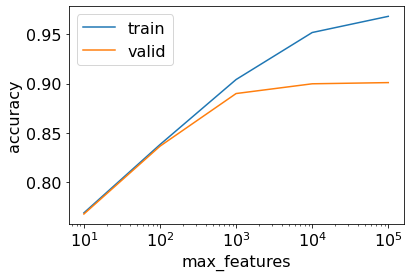

In [21]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [22]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.768771,0.767596
1,100,0.838053,0.836424
2,1000,0.904047,0.889824
3,10000,0.951739,0.899715
4,100000,0.968153,0.900926


It looks like having a greater value for the max_features hyperparameter is better as it increases the validation score

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
31.622776601683793


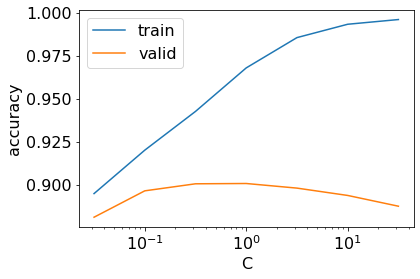

In [23]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [24]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.895058,0.881318
1,0.100000,0.920309,0.896658
2,0.316228,0.942843,0.900753
3,1.000000,0.968153,0.900926
4,3.162278,0.985770,0.898244
5,10.000000,0.993534,0.893977
6,31.622777,0.996273,0.887720


C = 1 seems to be the best since it has the best cv score and is not too under or over fit

#### 3(c)
3c rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above.{points:8} 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.


In [25]:
# BEGIN YOUR CODE HERE
best_max_feature = 100_000
best_C = 1.0
C_sizes = 10.0 ** np.arange(-1.5, 2, 0.5)
param_grid = {
    "countvectorizer__max_features": [10, 100, 1000, 10_000, 100_000],
    "logisticregression__C": [0.031623, 0.10000, 0.316228, 1.0000, 3.162278, 10.000000, 31.622777],
}

pipe = make_pipeline(
        CountVectorizer(stop_words="english"),
        LogisticRegression(max_iter=1000),
        )
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
#results = pd.DataFrame(grid_search.cv_results_)
#results = (pd.DataFrame(grid_search.cv_results_).set_index("rank_test_score").sort_index())
#print(results)

# END YOUR CODE HERE

0.896167956254643
{'countvectorizer__max_features': 100000, 'logisticregression__C': 1.0}


- What are the best values of `max_features` and `C` according to your grid search?(You can just print your best values){points:4}

best max features: 100000   best C: 1.0

#### 3(d)
3d rubric={points:5}

- Evaluate your final model on the test set.{points:3} 
    - Expected test accuracy is 0.899


In [26]:
# BEGIN YOUR CODE HERE
from sklearn.metrics import accuracy_score
pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=100_000),
        LogisticRegression(max_iter=1000,C=1),
        )
#print(pipe)
cross_val_results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))
print("validation accuracy: ",cross_val_results.mean().test_score)
pipe.fit(X_train,y_train)
X_test_predictions = pipe.predict(X_test)
X_test_score = pipe.score(X_test,y_test)
print("test accuracy: ",X_test_score)

# END YOUR CODE HERE

validation accuracy:  0.9009255984699335
test accuracy:  0.8941298581478492


- How does your test accuracy compare to your validation accuracy?{points:2}

The test accuracy is close to the validation accuracy meaning that the training model is meeting its expected performance.

## Exercise 4: Very short answer questions
rubric={points:15}

Each question is worth 3 points.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 

We want our test data to be a completely new set for our model and would break the Golden rule if we use the test data to fit.

2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?

Test data is used to measure how well the trained model does with new data. If test data influences the training, then it will give a worse classifier since it will not be an accurate model for new data.

3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.

I would choose predict since it is easier to compute a score with predict. predict_proba gives the probability of each target and not an estimate on how well the model performs.

4. What are two advantages of using sklearn `Pipeline`s? 

1) Using Pipeline improves readability of code
2) Only requires one fit method to apply all transformations to the data

5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

1) The best parameters are likely to be found since the search is completely randomized.
2) Can be customized to be faster than GridSearchCV

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment at Canvas. 
4. Finish the corresponding reflection survey.